# Path Planning On a Grid :: Revisiting Dijkstra aka Dijkstra with the SearchNodes

<center><img src="./img/1.png"/></center>

In this lab, we will consider the problem of finding the shortest path on a graph with a special structure, widely used in robotics and computer games — a grid. The grid consists of both free and blocked cells, and an agent can move from one free cell to another. The connectivity of the grid may vary; for example, a grid might be 4-connected when only cardinal moves (N, E, W, S) are allowed, or 8-connected when diagonal moves are allowed as well.

**In this lab, we assume that the grid is 4-connected**, meaning that only moves into the cardinal directions (N, E, W, S) are allowed. The cost of each move between two neighboring cells, represented as $v$ and $v'$, is uniform, with $cost(v, v') = 1$.

We will explore the seminal `Dijkstra` algorithm for finding the shortest path on a grid. However, our focus is on implementing this algorithm as a "heuristic search without heuristic," utilizing the distinct `SearchNode` structure, along with concepts like `Open` and `Closed`.

*The more advanced algorithms we will be discussing in the next labs will build upon much of this implementation. Therefore, it's crucial to ensure that your code is both correct and efficient.*

Your task is to complete the missing code fragments as per the provided prompts and execute every cell in this notebook. All tests should pass successfully.

Let's get started!


<center><img src="./img/2.png"/></center>

In [1]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

## Grid map representation 

In [2]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [3]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "#" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In the case of a 4-connected grid, the cost is always equal to 1. Consequently, the cost of each path is an integer.

However, please note that if the grid's connectivity exceeds 4, the cost of a transition may vary and may become fractional or even arbitrary (e.g., $\sqrt{2}$ for diagonal moves).

Recall that in this lab, we assume a 4-connected grid, meaning that only cardinal moves (up, down, left, right) are allowed, and as a result, all costs are integers.

In [4]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported.")

## Search Node

A Search node is a fundamental concept in heuristic search algorithms. It encapsulates data about the state of the problem (e.g., the position of a robot or agent on a grid) and the information needed to construct a search tree, including g-values, h-values, f-values, and a backpointer to its predecessor.

For Dijkstra's algorithm, technically, we don't need h and f values. However, we will introduce them now because they will be used in subsequent labs. For now, we set h to 0 for all nodes, resulting in f being equal to g for each node.


In [5]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node (always 0 for Dijkstra).
    f : float | int
        f-value of the node (always equal to g-value for Dijkstra).
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i, self.j) == (other.i, other.j)

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f
    
    def __hash__(self):
        """
        Creates hash of Node from tuple of it coordinates.
        """
        return hash((self.i, self.j))

## Visualization

In [6]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Re-expansions don't occur in Dijkstra's algorithm, but are included for potential future use.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

Example of the visualization

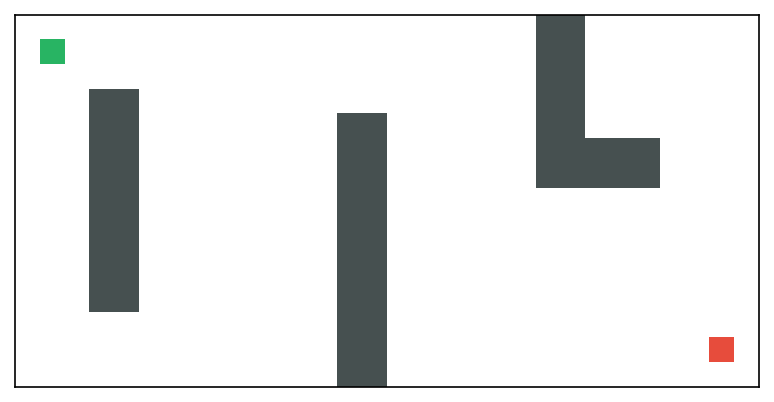

In [7]:
height = 15
width = 30
map_str = """
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
"""
cells = convert_string_to_cells(map_str)

test_map = Map(cells)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

## Implementing the Search Tree (i.e., OPEN and CLOSED)
An efficient implementation of the search tree (`OPEN` and `CLOSED`) is crucial for any search algorithm. Below, you'll find a basic implementation that uses lists to store the elements of `OPEN` and `CLOSED`. This method isn't very efficient, and you are tasked with creating your own implementations.

It's a good idea to start by modifying `CLOSED` since it's relatively straightforward. After making changes, ensure everything works OK—i.e., the search algorithms run faster and produce the right results. Following that, you can proceed to modify `OPEN`, which might be more challenging than it initially appears.

PS: Feel free to add additional fields, methods, method arguments, etc., to your implementations.


In [8]:
class SearchTreeL:
    """
    SearchTree that uses Lists for OPEN and CLOSED (NOT EFFICIENT).
    """

    def __init__(self):
        self._open = []  # List for the OPEN nodes
        self._closed = []  # List for the expanded nodes, i.e. CLOSED
        # No duplicates are present in a list-based implementation, so this always equals 0
        self._enc_open_duplicates = 0

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Typically, this is used to know
        the size of the search tree at the last iteration of the search,
        to assess the memory footprint of the algorithm.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Indicates whether OPEN is exhausted or not.
        If it is, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a (previously not expanded) node to the search tree (i.e., to OPEN).
        It can either be a totally new node (one we haven't encountered before)
        or a duplicate of a node that currently resides in OPEN.
        In this implementation, duplicates are detected upon addition. So,
        if the newly added node corresponds to the same state (has the same coordinates),
        we check if the g-value of the new node is better (lower) than the old one.
        If it is, we replace the old node with the new one (since it's better).
        Otherwise, we discard the new node.
        """
        for existing_node in self._open:
            if existing_node == item:  # Detect duplicates, ensuring OPEN never contains them
                if existing_node.g > item.g:
                    existing_node.g = item.g
                    existing_node.f = item.f  # Not strictly needed, but added for clarity
                    existing_node.parent = item.parent
                return
        self._open.append(item)

    def get_best_node_from_open(self) -> Node:
        """
        Extracts the best node (i.e., the one with the minimal key
        = min f-value = min g-value (for Dijkstra)) from OPEN.
        This node will be further expanded in the main search loop.
        """
        if not self._open:
            return None
        best_node = min(self._open, key=lambda node: node.f)
        self._open.remove(best_node)
        return best_node

    def add_to_closed(self, item: Node):
        self._closed.append(item)

    def was_expanded(self, item: Node) -> bool:
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

Next, you need to implement the search tree with the following features:
- A dictionary for CLOSED
- A priority queue for OPEN
- Lazy duplicate detection in OPEN

The last point implies that every time you generate a node that has not been previously expanded, you should simply add it to OPEN (i.e., add it to the priority queue where priority is determined by the `Node.__lt__` comparator). This approach may frequently lead to situations where the same node, possibly with a different $g$-value, is already in OPEN. To handle this, every time you extract the best node from OPEN, check if the node has been previously expanded. If the node has been expanded before, the current node is considered a 'bad duplicate' (a duplicate with a higher $g$-value) and should be discarded.

To monitor the number of OPEN duplicates encountered during the search, use `_enc_open_duplicates`. Increment this value by 1 every time you discard a 'bad duplicate'.

PS: Remember to handle the situation where only 'bad duplicates' remain in OPEN correctly.


In [9]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while True:
            if not self._open:
                return None
            
            best_node = heappop(self._open)
            
            if self.was_expanded(best_node): # node was expanded
                self._enc_open_duplicates += 1
                continue

            return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

## Validating the results


In [10]:
def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [11]:
def read_task_from_file(
    path: str,
) -> Tuple[npt.NDArray, int, int, int, int, float]:
    """
    Reads map, start/goal positions, and true value of path length between the given start and goal from a file.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    start_i, start_j : int, int
        Position of the start cell in the grid.
    goal_i, goal_j : int, int
        Position of the goal cell in the grid.
    length : float
        True value of the path's length between the given start and goal.
    """
    with open(path) as tasks_file:
        height = int(next(tasks_file))
        width = int(next(tasks_file))

        # Read the map section
        map_lines = [next(tasks_file) for _ in range(height)]
        map_str = "".join(map_lines)
        cells = convert_string_to_cells(map_str)

        start_i = int(next(tasks_file))
        start_j = int(next(tasks_file))
        goal_i = int(next(tasks_file))
        goal_j = int(next(tasks_file))
        length = float(next(tasks_file))

    return cells, start_i, start_j, goal_i, goal_j, length

When you finish implementing search algorithms, you'll naturally want to test them. The following functions will help you in doing just that.

`simple_test` runs the pathfinding algorithm on a single, straightforward instance, while `massive_test` executes it on a series of more involved instances. Both tests operate under the assumption that the search function follows the pattern below:

```
search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, search_tree_size, open, closed)
```

These automated tests anticipate that the search function, which is passed as an input, adheres to the following structure:

- `task_map` is the grid
- `start.i, start.j` are the  $(i, j)$ coordinates of the starting cell
- `goal.i, goal.j` are the $(i, j)$ coordinates of the goal cell
- `*optional arguments*` represent additional parameters of the search function, passed with *args. For instance, the heuristic function.
- `path_found` is `True` if a path was found and `False` otherwise
- `last_state` denotes the last state of the path. It returns `None` if a path was not found
- `steps` provides the number of search steps taken
- `search_tree_size` represents the number of nodes that make up the search tree at the final iteration of the algorithm, which equates to the size of the resultant search tree.
- `open` is an iterable collection of the nodes that form the search frontier (OPEN nodes)
- `closed` is an iterable collection of the expanded nodes (CLOSED)


In [12]:
def simple_test(search_function: Callable, task: Union[int, None], *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number from 0 to 24 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    def get_map_data():
        map_str = dedent(
            """
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
        """
        )
        cells = convert_string_to_cells(map_str)
        return Map(cells)

    task_map = get_map_data()
    starts = [
        (9, 0),
        (13, 0),
        (7, 28),
        (14, 29),
        (4, 1),
        (0, 17),
        (5, 6),
        (5, 20),
        (12, 2),
        (7, 28),
        (11, 9),
        (3, 2),
        (3, 17),
        (13, 20),
        (1, 1),
        (9, 10),
        (14, 6),
        (2, 0),
        (9, 28),
        (8, 6),
        (11, 6),
        (3, 0),
        (8, 9),
        (14, 7),
        (12, 4),
    ]
    goals = [
        (11, 20),
        (2, 19),
        (6, 5),
        (4, 18),
        (9, 20),
        (7, 0),
        (2, 25),
        (12, 4),
        (3, 25),
        (0, 12),
        (4, 23),
        (2, 24),
        (9, 2),
        (1, 6),
        (13, 29),
        (14, 29),
        (2, 28),
        (14, 16),
        (13, 0),
        (1, 27),
        (14, 25),
        (10, 20),
        (12, 28),
        (2, 29),
        (1, 29),
    ]
    lengths = [
        36,
        30,
        30,
        21,
        28,
        24,
        32,
        27,
        42,
        23,
        35,
        37,
        23,
        26,
        40,
        36,
        42,
        28,
        44,
        36,
        38,
        29,
        33,
        42,
        44,
    ]

    if (task is None) or not (0 <= task < 25):
        task = random.randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]

    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        if found:
            path, path_length = make_path(end_node)
            correct = int(path_length) == int(length)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: {correct}"
            )
        else:
            print("Path not found!")
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

In [13]:
def simple_test_not_found(search_function: Callable, task: Union[int, None], *args):
    """
    Tests the `search_function` on a task that is not expected to have a solution.

    Use a number from 0 to 1 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered (as expected).
     - 'Execution error' if an error occurred during the execution of the search_function.
    The function also provides a visualization of the task instance.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 1 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    def get_map_data():
        map_str = dedent(
            """
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . # # # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # . # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # . # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # . # # . . . . . . # . . . . . . . . 
            . . . # # . . . . . . # # # # . . . . . . # . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . # . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . # . . . . . . . .
            . . . . . . . . . . . . . # # . . . . . . # . . . . . . . .
        """
        )
        cells = convert_string_to_cells(map_str)
        return Map(cells)

    task_map = get_map_data()
    starts = [(0, 0), (0, 0)]
    goals = [(14, 25), (9, 12)]

    if (task is None) or not (0 <= task < 2):
        task = random.randint(0, 1)

    start = Node(*starts[task])
    goal = Node(*goals[task])

    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        if not found:
            draw(task_map, start, goal, None, *other_results)
            print(f"Path not found! Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: True")

        else:
            path, path_length = make_path(end_node)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: False"
            )
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

In [14]:
def massive_test(search_function, data_path, num_of_tasks, *args) -> Dict:
    """
    The `massive_test` function runs the `search_function` on a set of different tasks
    (for example, from the directory `data/`) using *args as optional arguments.
    For every task, it displays a short report:
     - 'Path found!' along with some statistics if a path was found.
     - 'Path not found!' if a path wasn't found.
     - 'Execution error' if an error occurred during the execution of the search_function.

    The function returns a dictionary containing statistics with the following keys:
     - "corr" — correctness of each path length (True/False).
     - "len" — the length of each path (0.0 if a path wasn't found).
     - "st_size" — the size of the resultant search tree for each task.
     - "steps" — the number of algorithm steps for each task.

    Parameters
    ----------
    search_function : Callable
        The implemented search method.
    data_path : str
        Path to the directory containing tasks.
    num_of_tasks : int
        The number of tasks to be used for evaluation.

    Returns
    -------
    stat : Dict
        A dictionary containing statistics.

    """
    stat = {
        "corr": [],
        "len": [],
        "st_size": [],
        "steps": [],
    }

    if num_of_tasks is None or num_of_tasks <= 0:
        print("Incorrect number of tasks. Testing halted!")
        return stat

    task_num = num_of_tasks

    for task_count in range(task_num):
        task_file_name = Path(data_path) / f"{task_count}.map"
        cells, start_i, start_j, goal_i, goal_j, length = read_task_from_file(task_file_name)
        task_map = Map(cells)
        try:
            (
                found,
                end_node,
                number_of_steps,
                search_tree_size,
                *other_results,
            ) = search_function(task_map, start_i, start_j, goal_i, goal_j, *args)

            if found:
                _, path_length = make_path(end_node)
                correct = int(path_length) == int(length)

                print(
                    f"Task: #{task_count}. Path found! Length: {path_length}. Search tree size: {search_tree_size}. "
                    f"Number of steps: {number_of_steps}. Correct: {correct}"
                )

                stat["len"].append(path_length)
                stat["corr"].append(correct)
            else:
                print(f"Task: #{task_count}. Path not found!")
                stat["len"].append(0.0)
                stat["corr"].append(False)

            stat["st_size"].append(search_tree_size)
            stat["steps"].append(number_of_steps)

        except Exception as e:
            print(f"Execution error: {e}")
            traceback.print_exc()

    return stat

## Dijkstra algorithm

The input is:
- map representation
- start/goal cells
- heuristic function $^*$
- a reference to the implementation of the SearchTree

$^*$ *Please note that technically, there is no need to pass heuristic function to the Dijkstra's algorithm. However, to unify it with $A^*$ (a heuristic search algorithm we will implement in the next lab), we keep this parameter as an input argument.*

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes


PS: You might also want to display, at the final iteration, the number of OPEN duplicates encountered during the search, as shown below:

```print("During the search, the following number of OPEN dublicates was encountered: ", dst.number_of_open_duplicates) ```


In [15]:
def dijkstra(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Optional[Callable],
    search_tree: Union[Type[SearchTreeL], Type[SearchTreePQD]],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implementation of Dijkstra algorithm.
    """

    dst = search_tree()  # Dijkstra's search tree
    steps = 0
    start_node = Node(start_i, start_j, g=0, h=0)
    dst.add_to_open(start_node)

    while not dst.open_is_empty():
        steps += 1
        current_node = dst.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(dst), dst.opened, dst.expanded
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_node = Node(neighbor_i, neighbor_j, g=neighbor_g, parent=current_node)
            
            if not dst.was_expanded(neighbor_node):
                dst.add_to_open(neighbor_node)
        
        dst.add_to_closed(current_node)
  
    return False, None, steps, len(dst), None, dst.expanded

## Now let's test the implementation.

Begin by executing the algorithm using the initial list-based search-tree implementation. Ensure that you receive the expected results on the given simple tests.


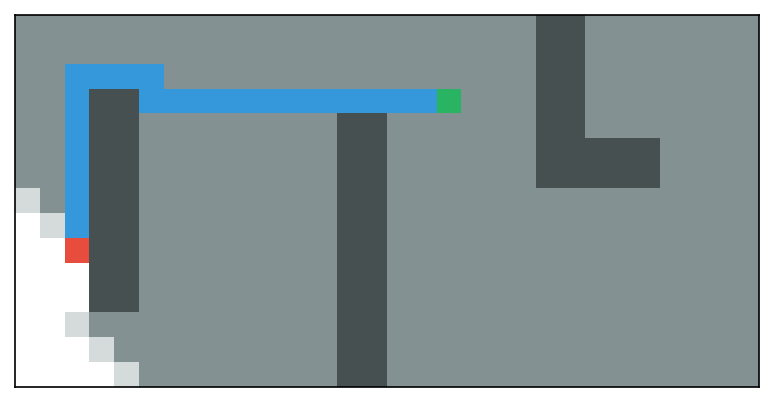

Path found! Length: 23. Search tree size: 371. Number of steps: 367. Correct: True
CPU times: user 108 ms, sys: 6.54 ms, total: 115 ms
Wall time: 114 ms


In [16]:
"""
The code should execute correctly if your Dijkstra implementation is accurate.
Experiment with the test instance number (the 2nd argument) to execute the search algorithm on various start/goal pairs.
"""
%time res = simple_test(dijkstra, 12, None, SearchTreeL)

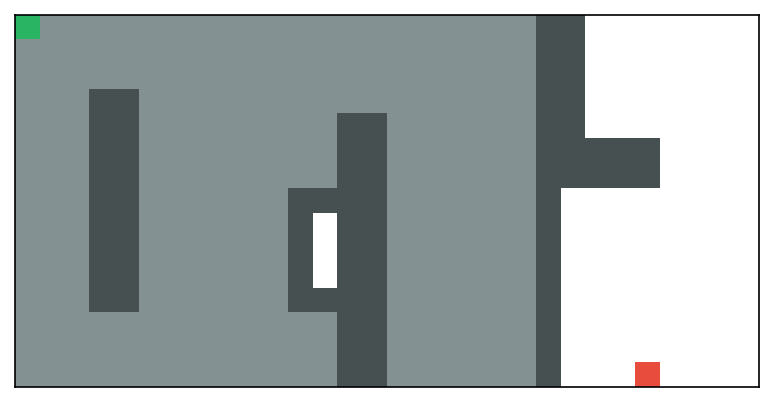

Path not found! Search tree size: 265. Number of steps: 265. Correct: True
CPU times: user 96.8 ms, sys: 87 µs, total: 96.8 ms
Wall time: 96.4 ms


In [17]:
"""
The code will execute correctly if the Dijkstra implementation properly handles cases where a path doesn't exist.
"""
%time res = simple_test_not_found(dijkstra, 0, None, SearchTreeL)

Now, integrate your optimized search tree implementation (`SearchTreePQD`), into Dijkstra.

You should observe an improvement in performance, indicated by a reduced runtime.

However, due to the lazy duplicate detection, the number of OPEN duplicates encountered during the search might be greater than zero. Consequently, the size of the final search tree might be larger (when compared to the list-based Dijkstra), as some duplicates might remain in OPEN at the search's final iteration.


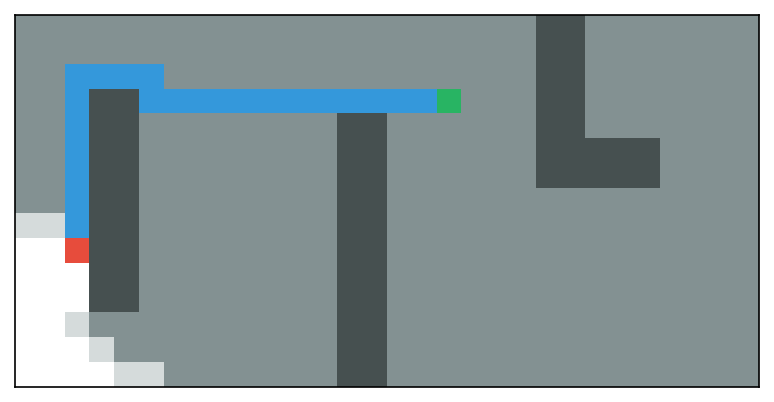

Path found! Length: 23. Search tree size: 377. Number of steps: 367. Correct: True
CPU times: user 72.6 ms, sys: 3.27 ms, total: 75.8 ms
Wall time: 74.7 ms


In [18]:
"""
The code should execute correctly if your Dijkstra implementation is accurate.
Experiment with the test instance number (the 2nd argument) to execute the search algorithm on various start/goal pairs.
"""
%time res = simple_test(dijkstra, 12, None, SearchTreePQD)

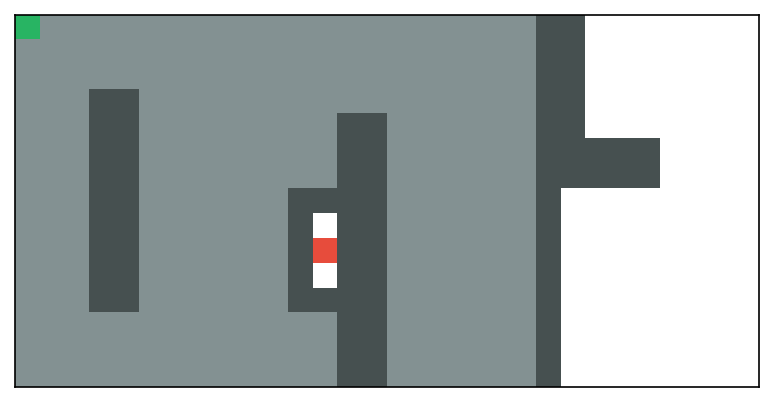

Path not found! Search tree size: 265. Number of steps: 266. Correct: True
CPU times: user 73.8 ms, sys: 3 ms, total: 76.8 ms
Wall time: 74.9 ms


In [19]:
"""
The code will execute correctly if the Dijkstra implementation properly handles cases where a path doesn't exist.
"""
%time res = simple_test_not_found(dijkstra, 1, None, SearchTreePQD)

The following cell runs the search algorithm on two larger instances.

The default (list-based) implementation of OPEN/CLOSED will be slow.

In [20]:
"""
This runs the search algorithm on two larger instances.
The default (list-based) implementation for OPEN/CLOSED will be slow.
"""
%time res = dijk_stat = massive_test(dijkstra, "data/", 2, None, SearchTreeL)

Task: #0. Path found! Length: 64. Search tree size: 1781. Number of steps: 1758. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 7451. Number of steps: 7449. Correct: True
CPU times: user 16.6 s, sys: 3.49 ms, total: 16.6 s
Wall time: 16.6 s


With your efficient implementation of OPEN/CLOSED solving the same large instances should take much less time.

In [21]:
"""
With your (non list-based) implementation of OPEN/CLOSED it should be much faster
"""
%time res = dijk_stat = massive_test(dijkstra, "data/", 2, None, SearchTreePQD)

Task: #0. Path found! Length: 64. Search tree size: 1800. Number of steps: 1750. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 7454. Number of steps: 7449. Correct: True
CPU times: user 97.3 ms, sys: 0 ns, total: 97.3 ms
Wall time: 97.5 ms


Finally, let's run your efficient implementation of Dijkstra on the full set of
large instances (9 instances in total). 

Indeed, every instance shall be solved correctly.

On my modern laptop (2022 Asus, Intel iCore7, 16Gb RAM, SSD) the entire test finishes 
in under 10 seconds.

In [22]:
"""
Lastly, test the efficient implementation of Dijkstra on the complete set of large instances (9 in total). 
Every test should execute correctly.

On my modern laptop (2022 Asus, Intel iCore7, 16Gb RAM, SSD) the entire test finishes 
in under 10 seconds.
"""
%time res = dijk_stat = massive_test(dijkstra, "data/", 9, None, SearchTreePQD)

Task: #0. Path found! Length: 64. Search tree size: 1800. Number of steps: 1750. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 7454. Number of steps: 7449. Correct: True
Task: #2. Path found! Length: 462. Search tree size: 45913. Number of steps: 45896. Correct: True
Task: #3. Path found! Length: 498. Search tree size: 44470. Number of steps: 44441. Correct: True
Task: #4. Path found! Length: 479. Search tree size: 47544. Number of steps: 47533. Correct: True
Task: #5. Path found! Length: 402. Search tree size: 28177. Number of steps: 28173. Correct: True
Task: #6. Path found! Length: 721. Search tree size: 112546. Number of steps: 112406. Correct: True
Task: #7. Path found! Length: 678. Search tree size: 77496. Number of steps: 77376. Correct: True
Task: #8. Path found! Length: 683. Search tree size: 95928. Number of steps: 95875. Correct: True
CPU times: user 4.9 s, sys: 73.2 ms, total: 4.97 s
Wall time: 4.99 s


In [23]:
np.array(dijk_stat["st_size"]).mean(), np.array(dijk_stat["steps"]).mean()

(51258.666666666664, 51211.0)